# SCA-resistant PQC Primitive Demo

In [1]:
# adjust "width:xx%"
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Settings:
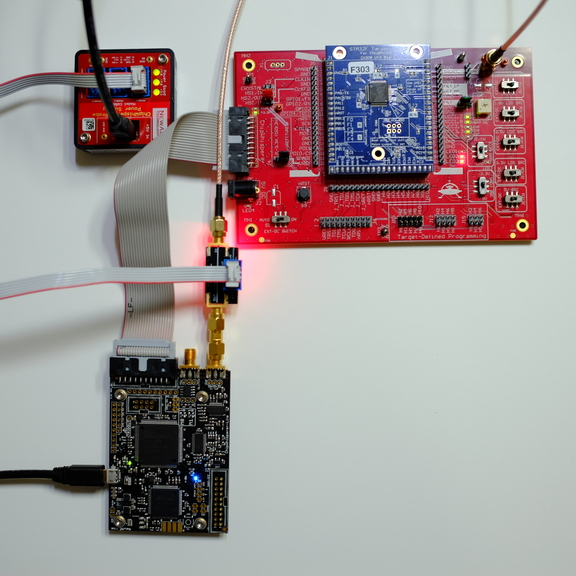

## Supported setup:

Supported setup:

SCOPE:
* OPENADC

PLATFORM:
* CW308_STM32F3

In [2]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F3'
CRYPTO_TARGET = 'PQC_DEMO'
num_traces = 1000 # 500 'Fixed + noise' / 500 random

## 1. Unprotected Version

### Building Unprotected Version

In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../pqc_demo
make PLATFORM=$1 CRYPTO_TARGET=$2 clean
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
.
Welcome to another exciting ChipWhisperer target build!!
.
Cleaning project:
rm -rf .dep
+--------------------------------------------------------
+ Built for platform CW308T: STM32F3 Target with:
+ CRYPTO_TARGET = PQC_DEMO
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------
Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
mkdir -p .dep
Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CW308_STM32F3 
.
Compiling:
-en     pqc_demo.c ...
-e Done!
.
Compiling:
-en     ../.

### Programming Target Board(U)

In [4]:
import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()

try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer")

INFO: Found ChipWhisperer


In [5]:
prog = cw.programmers.STM32FProgrammer

import time
time.sleep(0.05)
scope.default_setup()

def reset_target(scope):
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high'
    time.sleep(0.05)

In [6]:
fw_path = '../pqc_demo/pqc_demo-{}.hex'.format(PLATFORM)

In [7]:
cw.program_target(scope, prog, fw_path)

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 15635 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 15635 bytes


### Check Hello Message(U)

In [8]:
reset_target(scope)

In [9]:
print(target.read())

hello
ë    (( ((              (      (                hello



### Capturing Traces(U)

In [10]:
#Capture Traces
from chipwhisperer.common.traces import Trace
from tqdm.notebook import tnrange
import numpy as np
import time

scope.gain.db = 0
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 6000

ktp = cw.ktp.Basic()

traces_i = []
traces_j = []

for i in tnrange(num_traces, desc='Capturing traces'):
    key, text = ktp.next()
    
    scope.arm()
    target.simpleserial_write('p', text)
    time.sleep(0.1)

    ret = scope.capture(poll_done = False)
    wave = scope.get_last_trace(as_int = False)
    
    #Trace(wave, textin, textout, key)
    trace = Trace(wave, text, 0, key)
    
    if trace is None:
        continue

    if text[0] % 2 == 0:
        traces_i.append(trace)
    else:
        traces_j.append(trace)

#Convert traces to numpy arrays
trace_i_array = np.asarray([trace.wave for trace in traces_i])
trace_j_array = np.asarray([trace.wave for trace in traces_j])

Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


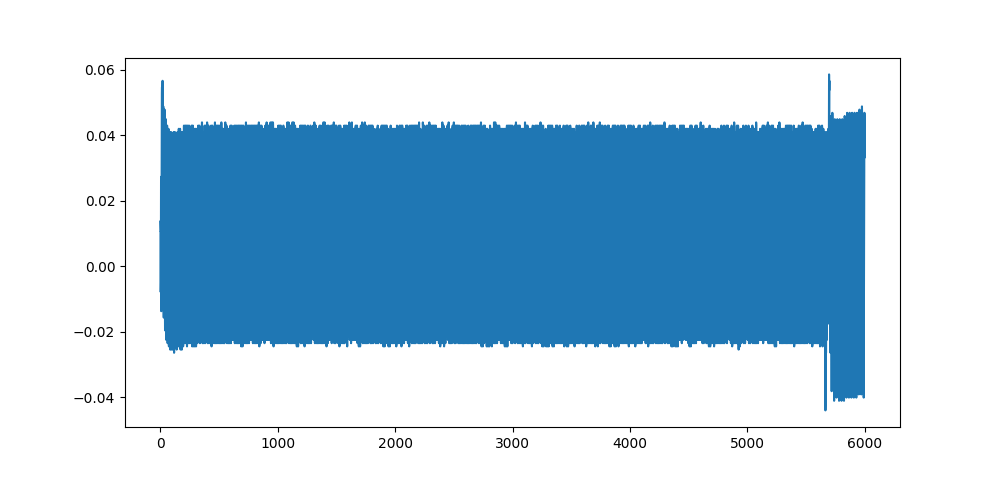

In [11]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure().set_figwidth(10)
plt.plot(trace_i_array[0])

In [12]:
import numpy as np

numtraces_i = np.shape(trace_i_array)[0]
numtraces_j = np.shape(trace_j_array)[0]

mean_i = np.mean(trace_i_array, axis=0, dtype=np.float64)
var_i = np.var(trace_i_array, axis=0, dtype=np.float64)
var_i = var_i / numtraces_i

mean_j = np.mean(trace_j_array, axis=0, dtype=np.float64)
var_j = np.var(trace_j_array, axis=0, dtype=np.float64)
var_j = var_j / numtraces_j

numerator = mean_i - mean_j
numerator = numerator * numerator
denominator = var_i + var_j

sost_unprotected = numerator / denominator

## 2. Protected Version

### Building Protected Version

In [13]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../pqc_demo
make PLATFORM=$1 CRYPTO_TARGET=$2 clean
make PLATFORM=$1 CRYPTO_TARGET=$2 EXTRA_OPTS="_CM"

Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
.
Welcome to another exciting ChipWhisperer target build!!
.
Cleaning project:
rm -rf .dep
+--------------------------------------------------------
+ Built for platform CW308T: STM32F3 Target with:
+ CRYPTO_TARGET = PQC_DEMO
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------
Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
mkdir -p .dep
Building for platform CW308_STM32F3 with CRYPTO_TARGET=PQC_DEMO
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CW308_STM32F3 
.
Compiling:
-en     pqc_demo.c ...
-e Done!
.
Compiling:
-en     ../.

### Programming Target Board(P)

In [14]:
import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()

try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer")

INFO: Found ChipWhisperer


In [ ]:
prog = cw.programmers.STM32FProgrammer

import time
time.sleep(0.05)
scope.default_setup()

def reset_target(scope):
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high'
    time.sleep(0.05)

In [15]:
fw_path = '../pqc_demo/pqc_demo-{}.hex'.format(PLATFORM)

In [16]:
cw.program_target(scope, prog, fw_path)

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 14703 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 14703 bytes


### Check Hello Message(P)

In [17]:
reset_target(scope)

In [18]:
print(target.read())

hello
ë:ºP)!J	(((((((ºû2:J!-  (    ((                          hello



### Capturing Traces(P)

In [ ]:
#Capture Traces
from chipwhisperer.common.traces import Trace
from tqdm.notebook import tnrange
import numpy as np
import time

scope.gain.db = 0
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 6000

ktp = cw.ktp.Basic()

cm_traces_i = []
cm_traces_j = []

for i in tnrange(num_traces, desc='Capturing traces'):
    key, text = ktp.next()
    
    scope.arm()
    target.simpleserial_write('p', text)
    time.sleep(0.1)

    ret = scope.capture(poll_done = False)
    wave = scope.get_last_trace(as_int = False)
    
    #Trace(wave, textin, textout, key)
    trace = Trace(wave, text, 0, key)
    
    if trace is None:
        continue

    if text[0] % 2 == 0:
        cm_traces_i.append(trace)
    else:
        cm_traces_j.append(trace)

#Convert traces to numpy arrays
cm_trace_i_array = np.asarray([trace.wave for trace in cm_traces_i])
cm_trace_j_array = np.asarray([trace.wave for trace in cm_traces_j])

Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure().set_figwidth(10)
plt.plot(cm_trace_i_array[0])

In [ ]:
import numpy as np

numtraces_i = np.shape(cm_trace_i_array)[0]
numtraces_j = np.shape(cm_trace_j_array)[0]

mean_i = np.mean(cm_trace_i_array, axis=0, dtype=np.float64)
var_i = np.var(cm_trace_i_array, axis=0, dtype=np.float64)
var_i = var_i / numtraces_i

mean_j = np.mean(cm_trace_j_array, axis=0, dtype=np.float64)
var_j = np.var(cm_trace_j_array, axis=0, dtype=np.float64)
var_j = var_j / numtraces_j

numerator = mean_i - mean_j
numerator = numerator * numerator
denominator = var_i + var_j

sost_protected = numerator / denominator

plt.figure().set_figwidth(10)
plt.plot(sost_unprotected[100:], 'g')
plt.plot(sost_protected[100:], 'b')

## Example of the result
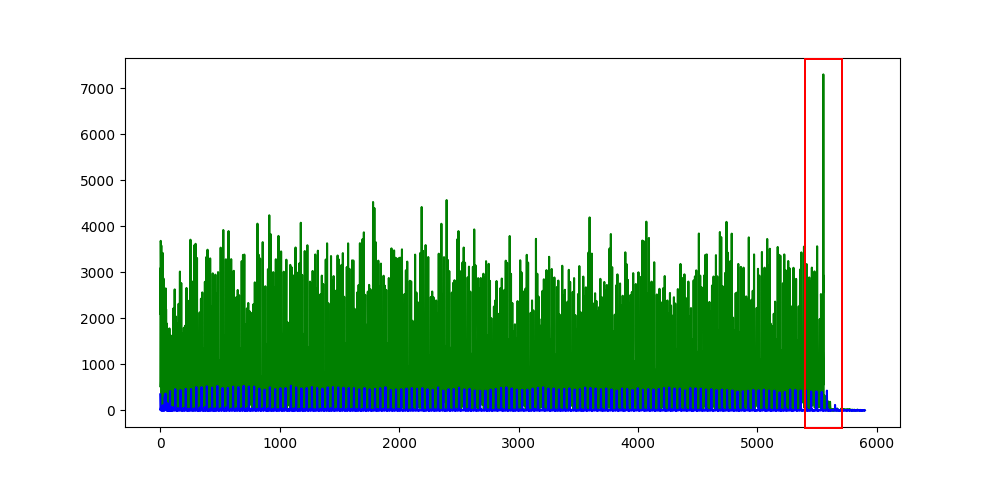
If we can observe the difference of SOST value on the POI(red square), demonstration is successful.